# Машинное обучение, РЭШ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 07.11.2020

Мягкий дедлайн: 23:59MSK 14.11.2020

Жесткий дедлайн: 23:59MSK 16.11.2020

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются на my.nes в виде Jupyter-notebook файла.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: 10!


В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
!pip install folium

In [2]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

%matplotlib inline

sns.set(style="darkgrid")

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

Давайте скачаем данные напрямую с kaggle. Для того, чтобы код работал в colab, нужно загрузить kaggle.json (можно скачать в аккаунте kaggle) с токеном. 

In [190]:
#!pip install kaggle
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!kaggle competitions download -c nyc-taxi-trip-duration

mkdir: cannot create directory ‘/root/.kaggle’: File exists
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.zip: Skipping, found more recently modified local copy (use --force to force download)


Считаем данные, сразу преобразовав pickup_datetime в datetime формат. 

In [191]:
train = pd.read_csv('train.zip', parse_dates=['pickup_datetime'])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 122.4+ MB


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [192]:
train.drop(columns = ['dropoff_datetime'], inplace = True)

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

In [193]:
train['trip_duration'].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

[]

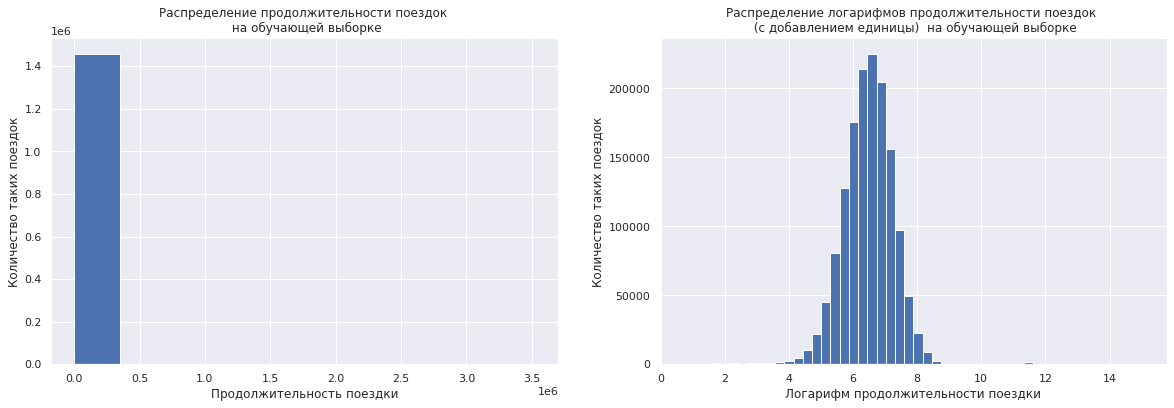

In [194]:
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (20, 6))

ax[0].hist(train['trip_duration'])
ax[0].set_title('Распределение продолжительности поездок \n на обучающей выборке')
ax[0].set_xlabel('Продолжительность поездки')
ax[0].set_ylabel('Количество таких поездок')
ax[0].grid(True)

ax[1].hist(np.log1p(train['trip_duration']),50)
ax[1].set_title('Распределение логарифмов продолжительности поездок \n (с добавлением единицы)  на обучающей выборке')
ax[1].set_xlabel('Логарифм продолжительности поездки')
ax[1].set_ylabel('Количество таких поездок')
ax[1].grid(True)

plt.plot()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

Мы видим, что значения распределены очень неравномерно. Левая гистограмма (на ней изображено распределение поездок) состоит всего из одного столбца, т.е. numpy.histogram (через него работает plt.hist) не удается подобрать равномерые границы бинов для отображения этого распределения. 

Напротив, картина улучшается если рассмотреть логарифмированную длительность поездок. Распределение принимает нормальный вид, что видно на гистограмме справа. Такое масштабирование улучшает сравнимость данных (не меняя порядок наблюдений), поэтому авторы и использовали RMSLE в качестве метрики. Если бы авторы использовали стандартную RMSE без логарифмирования, то эта метрика давала бы слишком большой вес наблюдениям с большой длительностью поездки, что не обосновано. 

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

Смотри комментарий выше со сравнением RMSE/RMSLE. 


На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: Заметим, что по определению $\hat{y}_i$ и $\hat{a}(x_i)$

$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y}_i - \hat{a}(x_i)\big)^2} = RMSE(X, \hat{y}, \hat{a})$$

Т.е. минимизация RMSLE для a эквивалентна минимизации RMSE для $\hat{a}$, которая в свою очередь эквивалентна минимизации MSE для $\hat{a}$. Далее, если специально не оговорено иное, под метрикой мы будем подразумевать и сравнивать RMSE, т.к. это удобнее. 

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [195]:
train['log_trip_duration'] = np.log1p(train['trip_duration']) 
# Гистограмма нарисована выше!
# И удалять я ничего не буду, дальше понадобится!
# train.drop(columns = ['trip_duration'], inplace=True)

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [196]:
def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

best_constant_prediction = train['log_trip_duration'].mean()

rmse(best_constant_prediction, train['log_trip_duration'])

0.7957592365412155

## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

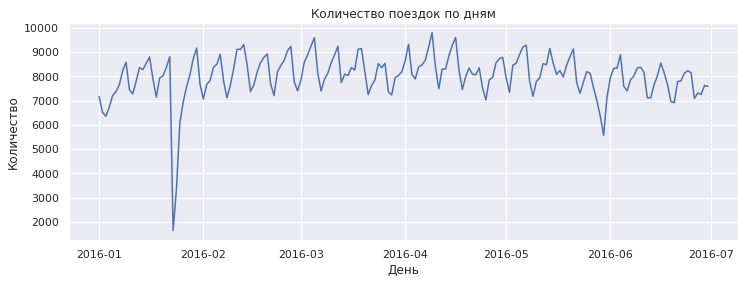

In [197]:
train['p_date'] = train['pickup_datetime'].dt.date

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(12,4))

ax.plot(train.groupby(train['p_date'])['id'].count())
ax.set_title('Количество поездок по дням')
ax.set_xlabel('День')
ax.set_ylabel('Количество')
ax.grid(True)

plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.


In [198]:
# Пики просадок:
print(train.groupby(train['p_date'])['id'].count().idxmin())
print(train.groupby(train['p_date'])['id'].count().tail(100).idxmin())

2016-01-23
2016-05-30


В конце января в Нью-Йорке был очень сильный снегопад, из-за которого  мы видим такую просадку в поездках. Что было в конце мая я так и не понял (но там и просадка не такая огромная).

Давайте сразу пометим эти аномальные периоды (из графика видно, что каждый период длиной примерно по два дня). 

In [199]:
train['first_anomaly'] = (train['p_date'] == datetime.date(2016, 1, 23))|(train['p_date'] == datetime.date(2016, 1, 24))
train['second_anomaly'] = (train['p_date'] == datetime.date(2016, 5, 29))|(train['p_date'] == datetime.date(2016, 5, 30))



Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

Так как задание не совсем однозначное, я решил нарисовать по графику для каждого дня недели. На каждом графике показано количество поездок в зависимости от времени дня.

[]

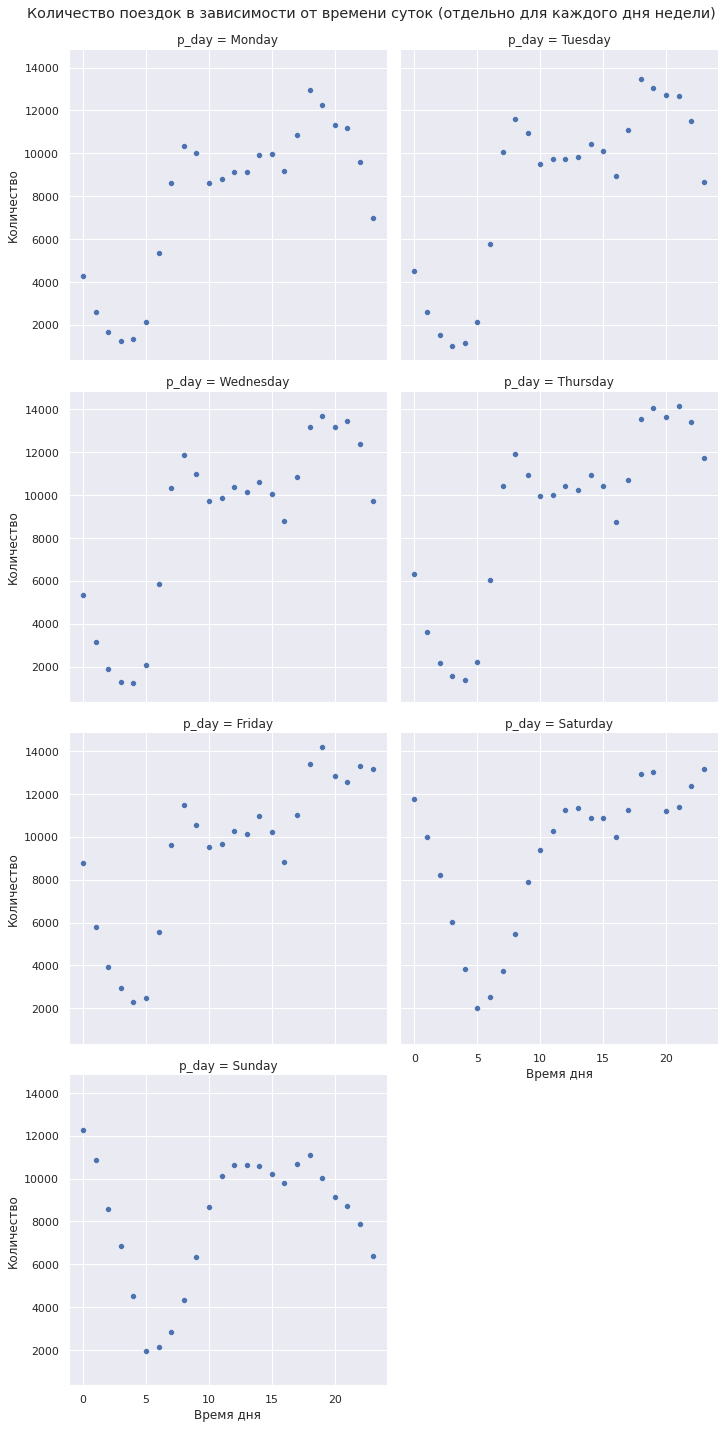

In [200]:
train['p_day'] = train['pickup_datetime'].dt.day_name()
# train['p_day'] = train['pickup_datetime'].dt.weekday+1
train['p_hour'] = train['pickup_datetime'].dt.hour

ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday', 'Saturday', 'Sunday']
g = sns.relplot(data = train.groupby(['p_day','p_hour'])['id'].count().to_frame(),
                x='p_hour', y = 'id', col = 'p_day', col_wrap =2, col_order=ordered_days)
g.set_axis_labels("Время дня", "Количество")
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Количество поездок в зависимости от времени суток (отдельно для каждого дня недели)')

plt.plot()

Еще посмотрим на:

[]

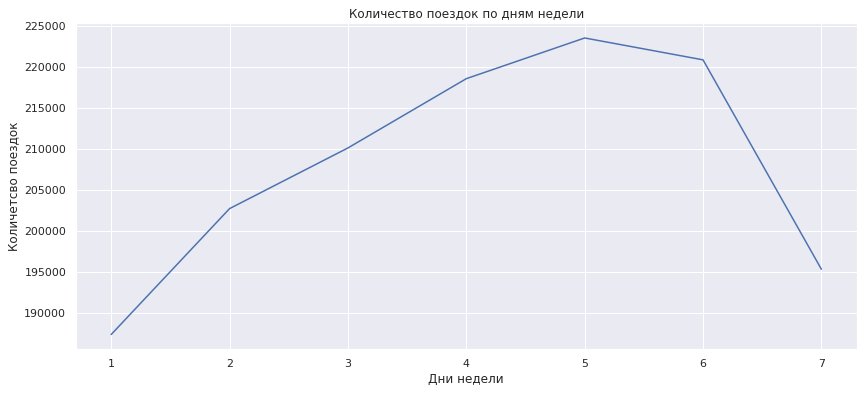

In [201]:
# Переобозначим дни числами, так будет удобнее для сортировки
train['p_day'] = train['pickup_datetime'].dt.weekday+1
fig, ax = plt.subplots(figsize = (14, 6))

ax.plot(train.groupby('p_day')['id'].count())
ax.set_title('Количество поездок по дням недели')
ax.set_xlabel('Дни недели')
ax.set_ylabel('Количетсво поездок')
ax.grid(True)

plt.plot()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

[]

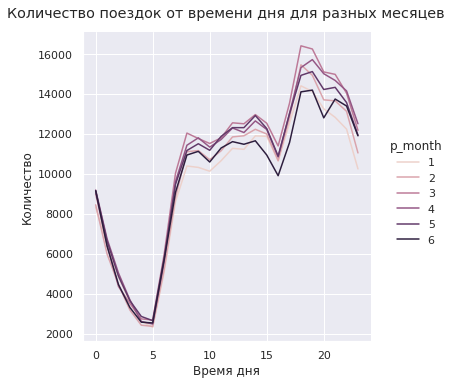

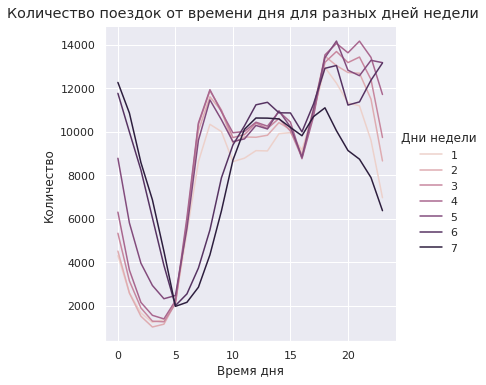

In [202]:
train['p_month'] = train['pickup_datetime'].dt.month
#fig, ax = plt.subplots(ncols = 2, figsize = (20,4))
g = sns.relplot(data = train.groupby(['p_month','p_hour'])['id'].count().to_frame(), 
            x='p_hour', y = 'id', hue = 'p_month', kind = 'line')
g.set_axis_labels("Время дня", "Количество")
g.fig.suptitle('Количество поездок от времени дня для разных месяцев', y=1.02)
g.fig.subplots_adjust(top=0.95)

g = sns.relplot(data = train.groupby(['p_day','p_hour'])['id'].count().to_frame(), 
            x='p_hour', y = 'id', hue = 'p_day', kind = 'line')
g.set_axis_labels("Время дня", "Количество")
g.fig.suptitle('Количество поездок от времени дня для разных дней недели', y=1.02)
g._legend.set_title('Дни недели')

plt.plot()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

*   **Месяцы**. Помесячно профиль поездок довольно стабилен. От зимы к лету наблюдается небольшое снижение числа поездок (видимо, люди больше гуляют в теплое время года), за исключением стабильных ночных поездок. 
*   **Дни недели**. На графиках мы видим в целом похожие паттерны от дня ко дню. Стоит отметить, что в ночи на сб и вскр поездок явно больше (люди возвращаются с развлечений). Так же вечером в вскр количество поездок проседает по сравнению с остальными днями (люди уже сидят дома перед новой рабочей неделей).   


**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [203]:
dtrain, dtest = train_test_split(train, test_size = 0.3, random_state = 111)
#X_train, X_test, y_train, y_test = train_test_split(train.drop('log_trip_duration', axis=1), 
#                                                    train['log_trip_duration'], test_size=0.3, random_state=10)

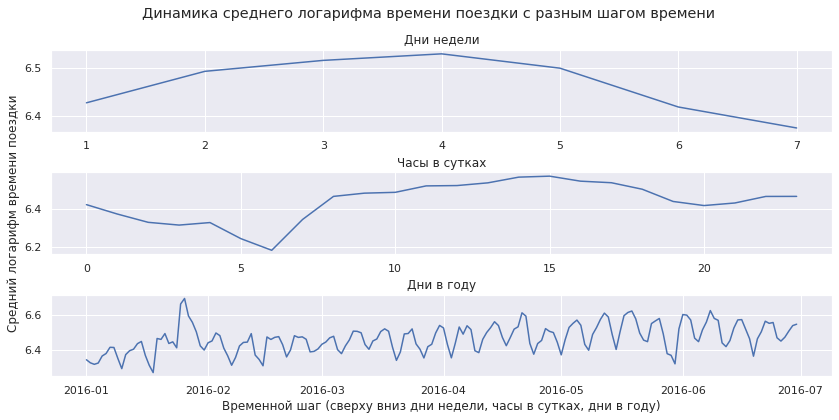

In [204]:
fig, ax = plt.subplots(ncols = 1, nrows = 3, figsize = (14, 6))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Динамика среднего логарифма времени поездки с разным шагом времени')

titles = ['Дни недели','Часы в сутках','Дни в году']
for i, symbol in enumerate(['p_day','p_hour','p_date']):
    ax[i].plot(dtrain.groupby(symbol)['log_trip_duration'].mean())
    ax[i].grid(True)
    ax[i].set_title(titles[i])

ax[1].set_ylabel('Средний логарифм времени поездки')
ax[2].set_xlabel('Временной шаг (сверху вниз дни недели, часы в сутках, дни в году)')
plt.show()
    

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

В целом, профили графиков похожи, но не идентичны. Например, зависимости от дней недели. Количество поездок достигает пика в пятницу (короткие поездки с работы в бар, в гости и т.п.). В то же время, логарифм длительности в среднем наибольший в середине недели, в четверг (видимо, поездки по делам). Аналогичная логика для часа в сутках - очень много поездок вечером и ранней ночью, но они короткие. Самые длинные же поездки во второй половине дня, после обеда. 

Первый аномальный период виден очень хорошо - резкое увеличение длительностей поездок в конце января - все встали в пробки из-за снегопада:) В конце мая мы наоборот видим снижение времени поездки. 

Кстати, из последнего графика видно, что средняя длительность поездки от зимы к лету немного выросла - виден слаый тренд. Может, люди ездят в более далекие поездки на пикники и подобные мероприятия. 

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

Все признаки уже добавлены выше. Единственное, что заменим дату на номер дня в году:

In [205]:
train['p_date'] = train['p_date'].apply(lambda x: x.timetuple().tm_yday)

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

Категориальными в нашем анализе являются:
*   День недели (малое количество, меньше важен порядок дней недели)
*   Аномальный период (бинарная переменная)

В то же время, численными являются:
*   Месяц
*   Час
*   Номер дня в году

Все эти три переменные имеют четкий порядковый характер на нашем датасете (даже для месяца мы увидели слабый эффект сезонности). Кроме того, на примере того же месяца - для нас не сильно важен эффект на границе (последний день марта и первый день апреля не сильно отличаются).

Однако стоит отметить, что отнесение месяца и часа к численным не является неоспоримым. 

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [206]:
dtrain, dtest = train_test_split(train, test_size = 0.3, random_state = 111)

numeric_features = ['p_month','p_hour','p_date']
categorical = ['p_day','first_anomaly','second_anomaly']
# numeric_features = ['p_date']
# categorical = ['p_month','p_hour','p_day','first_anomaly','second_anomaly']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

first_model = pipeline.fit(dtrain[numeric_features+categorical], dtrain['log_trip_duration'])

y_pred_train = first_model.predict(dtrain[numeric_features+categorical])
print("Train RMSE = %.4f" % rmse(dtrain['log_trip_duration'], y_pred_train))
y_pred = first_model.predict(dtest[numeric_features+categorical])
print("Test RMSE = %.4f" % rmse(dtest['log_trip_duration'], y_pred))

Train RMSE = 0.7928
Test RMSE = 0.7921


Можно, конечно, использовать другой вариант с разделением на категориальные и численные переменные, но он даст прирост всего с 0.7921 до 0.7884. Прирост небольшой и для меня выглядит скорее как переобучение, поэтому дальше буду использовать оговоренный выше вариант.  

## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [207]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [208]:
show_circles_on_map(train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [209]:
show_circles_on_map(train.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

Хорошо видны несколько групп точек:

*   аэропорт Кеннеди на востоке
*   аэропорт Лу-Гуардия на набережной (неподалеку от Манхэттена)
*   аэропорт Newark на западе

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [210]:
! pip install haversine
from haversine import haversine_vector

train['haversine'] = haversine_vector(train[['pickup_longitude','pickup_latitude']], train[['dropoff_longitude','dropoff_latitude']])

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [211]:
train['log_haversine'] = np.log1p(train['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [212]:
train[['haversine','log_haversine', 'log_trip_duration']].dropna().corr()

,haversine,log_haversine,log_trip_duration
haversine,1.000000,0.858161,0.520549
log_haversine,0.858161,1.000000,0.675784
log_trip_duration,0.520549,0.675784,1.000000


Действительно, корреляция логарифмов выше.

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

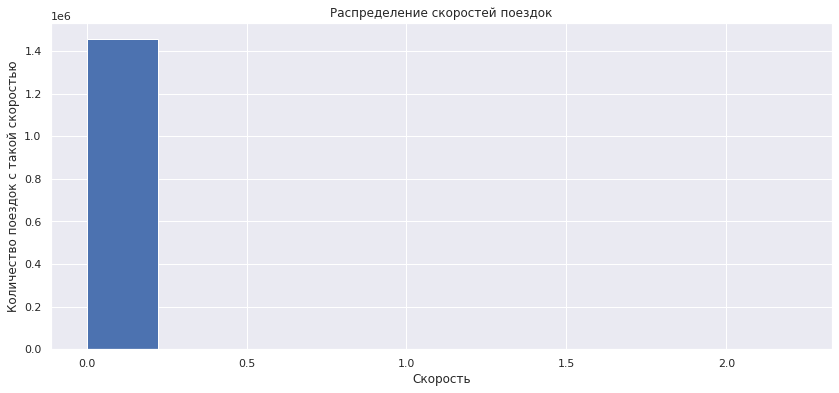

In [213]:
train['speed'] = np.exp(train['log_haversine'] - train['log_trip_duration'])

fig, ax = plt.subplots(figsize = (14, 6))

ax.hist(train['speed'])
ax.set_title('Распределение скоростей поездок')
ax.set_xlabel('Скорость')
ax.set_ylabel('Количество поездок с такой скоростью')
ax.grid(True)

plt.show()

In [214]:
train['speed'].describe()

count    1.458644e+06
mean     5.572247e-03
std      8.843550e-03
min      6.677932e-07
25%      3.148358e-03
50%      4.577028e-03
75%      6.521865e-03
max      2.219930e+00
Name: speed, dtype: float64

Не будем удивляться таким значениям скоростей, ведь они меряются в км/сек :)

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

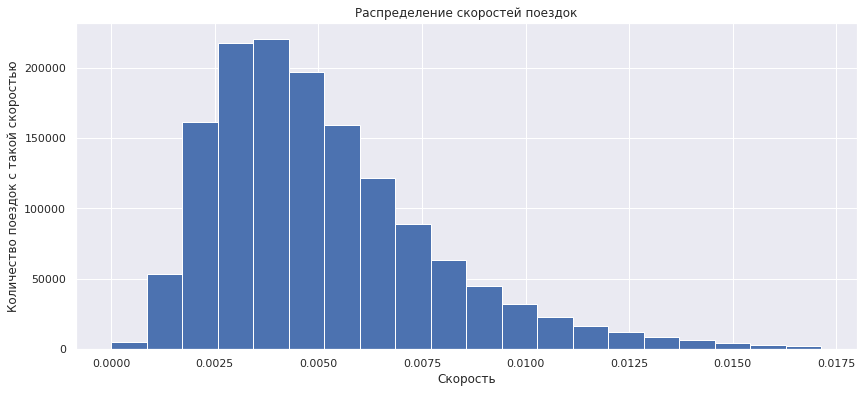

In [215]:
fig, ax = plt.subplots(figsize = (14, 6))

# отрежем 1% верхних значений
border = train['speed'].quantile(0.99)

ax.hist(train.loc[ train['speed'] < border ,'speed'], 20)
ax.set_title('Распределение скоростей поездок')
ax.set_xlabel('Скорость')
ax.set_ylabel('Количество поездок с такой скоростью')
ax.grid(True)

plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

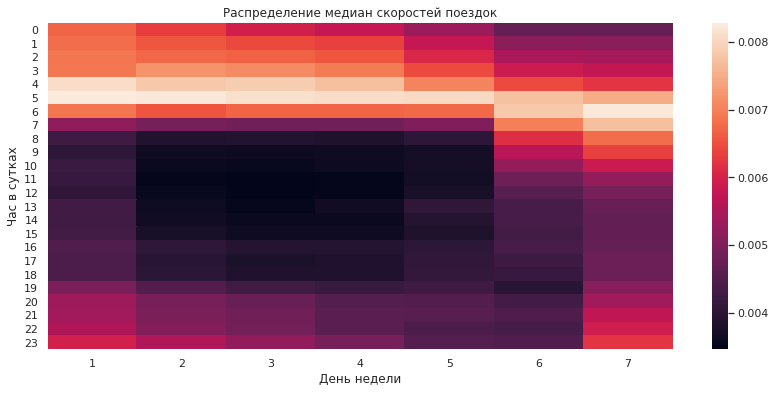

In [216]:
data_for_heatmap = train.groupby(['p_day','p_hour'])['speed'].median().to_frame()
data_for_heatmap = data_for_heatmap.reset_index().pivot('p_hour','p_day','speed')

fig, ax = plt.subplots(figsize = (14, 6))

ax = sns.heatmap(data_for_heatmap)
ax.set_title('Распределение медиан скоростей поездок')
ax.set_xlabel('День недели')
ax.set_ylabel('Час в сутках')

plt.show()

In [217]:
train.drop(columns='speed',inplace=True)

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

Потому что мы расчитывали скорость на основании таргета (и расстояния). Нехорошо использовать производные таргета в его предсказании (тавтологическая, переобученная модель).

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Видно, что по будним с 8 до 18/19 движение стоит. Чуть меньше в понедельник, но в целом - это явно зона пробок. Напротив, ночью в те же дни дороги свободны - скорость максимальна. Для выходных картинка похожая, но немного размытая и сдвинутая на несколько часов вперед. 

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [218]:
train['traffic_jam'] = ((train['p_day']<=5) & (train['p_hour']>6) & (train['p_hour']<=19))| \
  ((train['p_day']>5) & (train['p_hour']>11) & (train['p_hour']<=19))
train['open_roads'] = ((train['p_day']<=5) & (train['p_hour']<=6))| \
  ((train['p_day']>5) & (train['p_hour']>3) & (train['p_hour']<=8))

**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

Пусть эти две точки - Kennedy International Airport (Latitude: 40.6413, Longitude: -73.7781) и Newark Liberty International Airport (Latitude: 40.7026 Longitude: -74.1878). Отнесем все точки рядом с этими координатами (с небольшм запасом) к этим аэропортам:

In [219]:
# Для проверки построим границы зон, точки из которых мы будем относить к аэропортам:
u_lat = 40.6413 + 0.01
d_lat = 40.6413 - 0.01
u_lon = -73.7781 + 0.02
d_lon = -73.7781 - 0.02

u_lat_n = 40.6926 + 0.01
d_lat_n = 40.6926 - 0.01
u_lon_n = -74.1878 + 0.02
d_lon_n = -74.1878 - 0.02

airport = {'lat': [u_lat,u_lat,d_lat,d_lat,u_lat_n,u_lat_n,d_lat_n,d_lat_n], \
           'lon': [u_lon,d_lon,u_lon,d_lon,u_lon_n,d_lon_n,u_lon_n,d_lon_n]}

show_circles_on_map(pd.DataFrame(data=airport), "lat", "lon", "green")

In [220]:
# Ширина рамки выбрана исходя из здравого смысла и карты с координатами: 0.01, 0.02

u_lat = 40.6413 + 0.01
d_lat = 40.6413 - 0.01
u_lon = -73.7781 + 0.02
d_lon = -73.7781 - 0.02
train['air_k_start'] = (d_lat <= train['pickup_latitude']) & (train['pickup_latitude'] <= u_lat) & \
    (d_lon <= train['pickup_longitude']) & (train['pickup_longitude'] <= u_lon)
train['air_k_finish'] = (d_lat <= train['dropoff_latitude']) & (train['dropoff_latitude'] <= u_lat) & \
    (d_lon <= train['dropoff_longitude']) & (train['dropoff_longitude'] <= u_lon)

u_lat = 40.7026 + 0.01
d_lat = 40.7026 - 0.01
u_lon = -74.1878 + 0.02
d_lon = -74.1878 - 0.02
train['air_n_start'] = (d_lat <= train['pickup_latitude']) & (train['pickup_latitude'] <= u_lat) & \
    (d_lon <= train['pickup_longitude']) & (train['pickup_longitude'] <= u_lon)
train['air_n_finish'] = (d_lat <= train['dropoff_latitude']) & (train['dropoff_latitude'] <= u_lat) & \
    (d_lon <= train['dropoff_longitude']) & (train['dropoff_longitude'] <= u_lon)


Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

In [221]:
train['log_trip_duration'].describe()

count    1.458644e+06
mean     6.466978e+00
std      7.957595e-01
min      6.931472e-01
25%      5.986452e+00
50%      6.496775e+00
75%      6.981006e+00
max      1.507575e+01
Name: log_trip_duration, dtype: float64

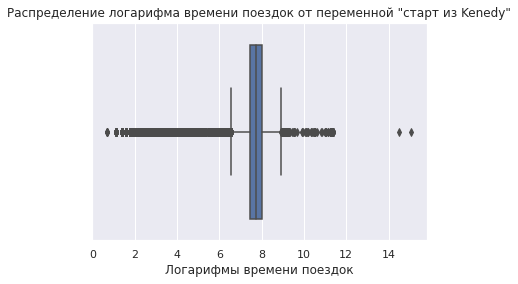

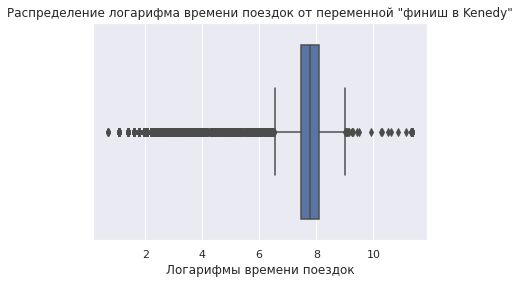

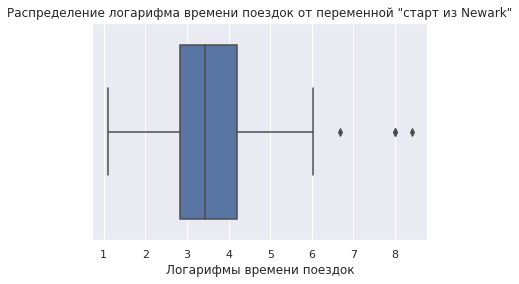

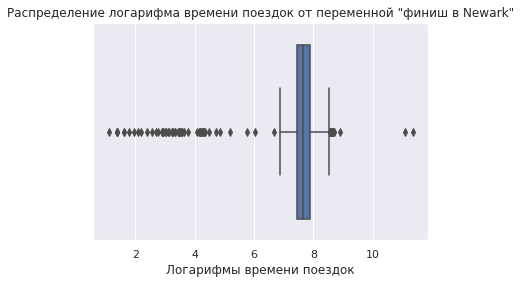

In [222]:
sns.boxplot(x='log_trip_duration',data=train[train['air_k_start']==1])
plt.title('Распределение логарифма времени поездок от переменной "старт из Kenedy"')
plt.xlabel('Логарифмы времени поездок')
plt.show()

sns.boxplot(x='log_trip_duration',data=train[train['air_k_finish']==1])
plt.title('Распределение логарифма времени поездок от переменной "финиш в Kenedy"')
plt.xlabel('Логарифмы времени поездок')
plt.show()

sns.boxplot(x='log_trip_duration',data=train[train['air_n_start']==1])
plt.title('Распределение логарифма времени поездок от переменной "старт из Newark"')
plt.xlabel('Логарифмы времени поездок')
plt.show()

sns.boxplot(x='log_trip_duration',data=train[train['air_n_finish']==1])
plt.title('Распределение логарифма времени поездок от переменной "финиш в Newark"')
plt.xlabel('Логарифмы времени поездок')
plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

При среднем log_trip_duration в 6.46, видно, что наши переменные отделяют нестандартные поездки, т.е. какую-то силу признаки имеют. Единственное непонятное - старт из Newark имеет низкую длительность поездки в среднем, тогда как все остальные - высокую относительное средней по всей выборке. 

In [223]:
train['air_n_start'].value_counts()

False    1458589
True          55
Name: air_n_start, dtype: int64

Как видим, эта переменная очень редко срабатывает, поэтому низкое среднее значение можно отнести к артефактам. 

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [224]:
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, up,left,down,right, nrows,ncols):
    self.up = up
    self.left = left
    self.down = down
    self.right = right
    self.nrows = nrows
    self.ncols = ncols
    self.borders_lon = np.linspace(start = self.left, stop = self.right, num = ncols+1)
    # self.borders_lon = np.arange(start = self.left, stop = self.right+(self.right-self.left)/self.ncols, 
    #                              step = (self.right-self.left)/self.ncols)
    self.borders_lat = np.linspace(start = self.down, stop = self.up, num = nrows+1)
    # self.borders_lat = np.arange(start = self.down, stop = self.up+(self.up-self.down)/self.nrows, 
    #                              step = (self.up-self.down)/self.nrows)

  def which_cell(self, long, lat):
    x = np.searchsorted(self.borders_lon, long)-1
    y = np.searchsorted(self.borders_lat, lat)-1
    number = x + y*self.ncols
    number[(x==-1)|(x==self.ncols)|(y==-1)|(y==self.nrows)]=-1
    return number

Для инициализации класс выше принимает параметры сетки. Затем в единственный метод класса можно запихивать векторы координат, чтобы получать номера ячеек (с учетом -1 за пределами сетки). Чтобы не раздувать класс (дублируя свойство), мы примением одну и ту же функцию к стартовой точке и финальной отдельно. Все параметры сетки (объявленной ниже) взяты исходя из здравого смысла.

In [225]:
m = MapGridTransformer(up=40.8, left=-74.02, down = 40.7, right = -73.94, nrows = 4, ncols = 4)
train['pickup_cell'] = m.which_cell(train['pickup_longitude'], train['pickup_latitude'])
train['dropoff_cell'] = m.which_cell(train['dropoff_longitude'], train['dropoff_latitude'])

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [233]:
dtrain, dtest = train_test_split(train, test_size = 0.3, random_state = 111)

numeric_features = ['p_month','p_hour','p_date','log_haversine']
categorical = ['p_day','first_anomaly','second_anomaly',
               'pickup_cell','dropoff_cell',
               'open_roads','traffic_jam',
               'air_k_start','air_k_finish','air_n_start','air_n_finish']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

second_model = pipeline.fit(dtrain[numeric_features+categorical], dtrain['log_trip_duration'])
y_pred_train = second_model.predict(dtrain[numeric_features+categorical])
y_pred = second_model.predict(dtest[numeric_features+categorical])
print("Train RMSE = %.4f" % rmse(dtrain['log_trip_duration'], y_pred_train))
print("Test RMSE = %.4f" % rmse(dtest['log_trip_duration'], y_pred))

Train RMSE = 0.5475
Test RMSE = 0.5482


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

* Vendor_id может оказаться полезным, если есть структурные отличия между провайдерами, связанные с длительностью поездки. Например, один из них работает только в центре острова => у него в среднем поездки будут короче
* Количество пассажиров может порешать на экстремальных значениях. Например, если едет 6+ человек, мб это обычно поездки особого типа (например, на пикник) и они отличаются в среднем по длительности (дольше в примере)
* Отказ связи может быть полезен по той же причине. Например, если связь обычно теряется за городом, куда далеко (и дольше) ехать.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [228]:
print(train['vendor_id'].nunique())
print(train['passenger_count'].nunique())
print(train['store_and_fwd_flag'].nunique())

2
10
2


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

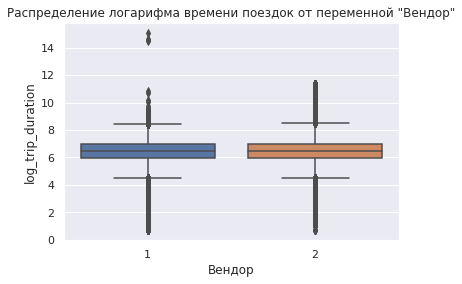

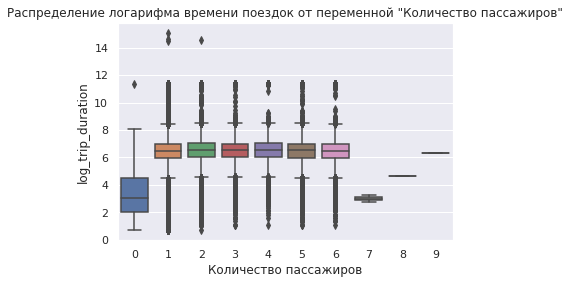

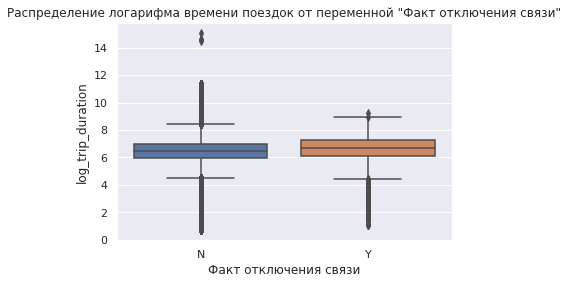

In [229]:
sns.boxplot(x='vendor_id', y='log_trip_duration',  data=train)
plt.title('Распределение логарифма времени поездок от переменной "Вендор"')
plt.xlabel('Вендор')
plt.show()

sns.boxplot(x='passenger_count', y='log_trip_duration',  data=train)
plt.title('Распределение логарифма времени поездок от переменной "Количество пассажиров"')
plt.xlabel('Количество пассажиров')
plt.show()

sns.boxplot(x='store_and_fwd_flag', y='log_trip_duration',  data=train)
plt.title('Распределение логарифма времени поездок от переменной "Факт отключения связи"')
plt.xlabel('Факт отключения связи')
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [230]:
train['vendor_id'] = train['vendor_id']-1
d = {'N' : 0, 'Y' : 1}
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].map(d)

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

Vendor_id и store_and_fwd_flag не похожи на сильные признаки: они не различиают (по крайней мере из графиков это не видно) распределения времени поездки. Может быть поможет количество пассажиров в нестандартных кейсах, но это еще надо проверять.

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [234]:
dtrain, dtest = train_test_split(train, test_size = 0.3, random_state = 111)

numeric_features = ['p_month','p_hour','p_date','log_haversine']
categorical = ['p_day','first_anomaly','second_anomaly',
               'pickup_cell','dropoff_cell',
               'open_roads','traffic_jam',
               'air_k_start','air_k_finish','air_n_start','air_n_finish',
               'vendor_id','passenger_count','store_and_fwd_flag']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

third_model = pipeline.fit(dtrain[numeric_features+categorical], dtrain['log_trip_duration'])
y_pred_train = third_model.predict(dtrain[numeric_features+categorical])
y_pred = third_model.predict(dtest[numeric_features+categorical])
print("Train RMSE = %.4f" % rmse(dtrain['log_trip_duration'], y_pred_train))
print("Test RMSE = %.4f" % rmse(dtest['log_trip_duration'], y_pred))

Train RMSE = 0.5471
Test RMSE = 0.5478


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

Да, видим, что эти три признака нам дали мало (ничего). Не будем их дальше брать.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

In [235]:
train['trip_duration'].describe(percentiles = [0.0001,0.001,0.01,0.1])

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
0.01%    2.000000e+00
0.1%     7.000000e+00
1%       8.700000e+01
10%      2.450000e+02
50%      6.620000e+02
max      3.526282e+06
Name: trip_duration, dtype: float64

Видим, что 0.1% поездок из выборки длились меньше 7 секунд! Вообще, на левом конце:

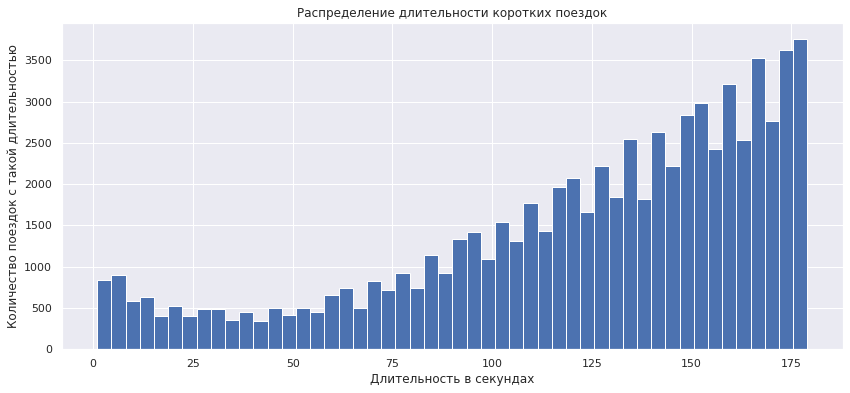

In [236]:
fig, ax = plt.subplots(figsize = (14, 6))


border = train['trip_duration'].quantile(0.05)

ax.hist(train.loc[ train['trip_duration'] < border ,'trip_duration'], 50)
ax.set_title('Распределение длительности коротких поездок')
ax.set_xlabel('Длительность в секундах')
ax.set_ylabel('Количество поездок с такой длительностью')
ax.grid(True)

plt.show()

Кажется, мы можем спокойно удалить все поездки, которые длились меньше 30 секунд. Это не очень много наблюдений (что плюс), а такие поездки явно выбросы и не стоит на них обучаться (скорее всего, такая длительность не преднамеренная. Мб это случаи аварий, отмен, возвратов и т.д.)

In [237]:
train['haversine'].describe(percentiles = [0.99,0.999,0.9999])

count     1.458644e+06
mean      2.876100e+00
std       4.435293e+00
min       0.000000e+00
50%       1.531211e+00
99%       2.254709e+01
99.9%     2.582000e+01
99.99%    4.567619e+01
max       8.519696e+02
Name: haversine, dtype: float64

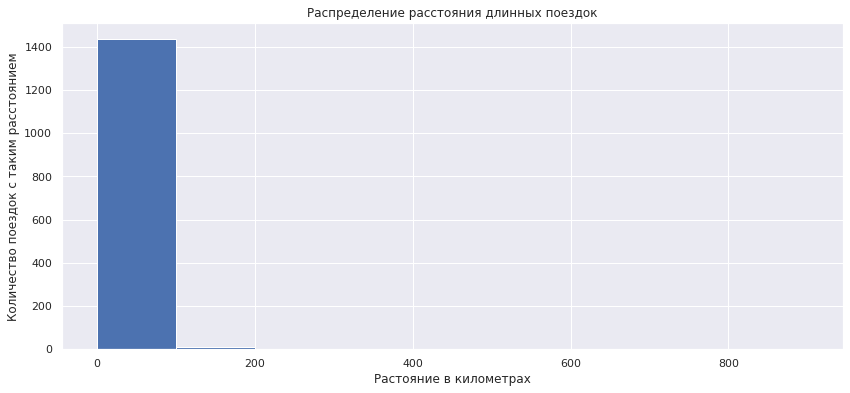

In [238]:
fig, ax = plt.subplots(figsize = (14, 6))

border = train['haversine'].quantile(0.999)

ax.hist(train.loc[ train['haversine'] > border ,'haversine'], bins = np.arange(0,1000,step=100))
ax.set_title('Распределение расстояния длинных поездок')
ax.set_xlabel('Растояние в километрах')
ax.set_ylabel('Количество поездок с таким расстоянием')
ax.grid(True)

plt.show()

Видно, что есть куча поездок с большим расстоянием. Кажется, их тоже нелогично использовать для обучения, ведь мы обсуждаем внутригородское такси (Манхеттен в длину немногим больше 20км). Давайте удалим из выборки все поездки, где расстояние больше 200 км. Такие наблюдения явно не про городское такси (даже если ездить кругами). 

In [239]:
err = np.abs(second_model.predict(train[numeric_features+categorical]) - train['log_trip_duration'])
err.describe(percentiles = [0.99,0.999,0.9999])

/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


count     1.458644e+06
mean      3.930516e-01
std       3.814285e-01
min       6.309689e-07
50%       3.080133e-01
99%       1.552757e+00
99.9%     4.584916e+00
99.99%    5.578501e+00
max       9.071541e+00
Name: log_trip_duration, dtype: float64

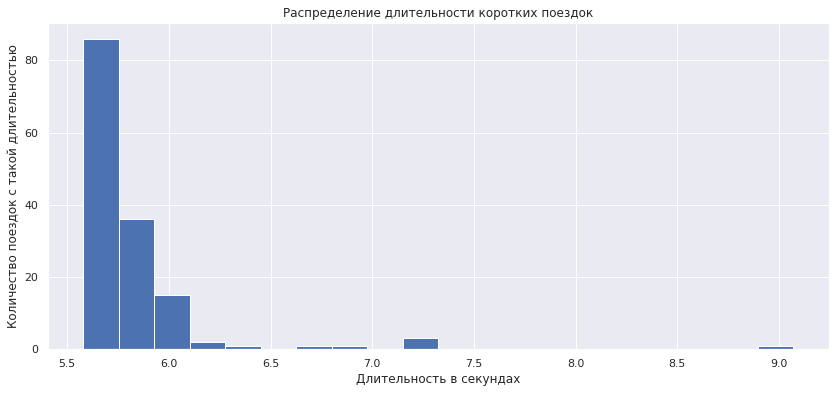

In [240]:
fig, ax = plt.subplots(figsize = (14, 6))

border = err.quantile(0.9999)

ax.hist(err[ err > border ], 20)
ax.set_title('Распределение длительности коротких поездок')
ax.set_xlabel('Длительность в секундах')
ax.set_ylabel('Количество поездок с такой длительностью')
ax.grid(True)

plt.show()


Аналогично, давайте удалим наблюдения с остатком больше 5. Похожи на выбросы:)

In [242]:
# Сколько таких наблюдени?
print(train[train['trip_duration'] <= 30].count()[1])
print(train[train['haversine'] >= 200].count()[1])
print(train[err > 5].count()[1])

4890
10
870


In [243]:
train = train[train['trip_duration'] > 30]
train = train[train['haversine'] < 200]
train = train[err < 5]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [244]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452881 entries, 0 to 1458643
Data columns (total 27 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1452881 non-null  object        
 1   vendor_id           1452881 non-null  int64         
 2   pickup_datetime     1452881 non-null  datetime64[ns]
 3   passenger_count     1452881 non-null  int64         
 4   pickup_longitude    1452881 non-null  float64       
 5   pickup_latitude     1452881 non-null  float64       
 6   dropoff_longitude   1452881 non-null  float64       
 7   dropoff_latitude    1452881 non-null  float64       
 8   store_and_fwd_flag  1452881 non-null  int64         
 9   trip_duration       1452881 non-null  int64         
 10  log_trip_duration   1452881 non-null  float64       
 11  p_date              1452881 non-null  int64         
 12  first_anomaly       1452881 non-null  bool          
 13  second_anoma

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [245]:
for var in categorical:
  print(train[var].value_counts())
  print('\n')

5    222676
6    220006
4    217686
3    209415
2    201982
7    194442
1    186674
Name: p_day, dtype: int64


False    1447880
True        5001
Name: first_anomaly, dtype: int64


False    1441001
True       11880
Name: second_anomaly, dtype: int64


 5     268028
 10    256412
 9     235371
-1     129779
 4      96870
 14     86365
 15     82346
 0      79574
 11     62529
 1      58851
 6      48795
 13     25884
 8      11500
 3       5228
 2       3349
 7       1993
 12         7
Name: pickup_cell, dtype: int64


 10    239870
 5     226737
 9     207123
-1     198639
 15     90197
 14     84229
 4      83688
 0      80011
 11     64596
 6      54623
 1      53079
 13     25980
 8      16448
 3      10903
 2       9341
 7       7368
 12        49
Name: dropoff_cell, dtype: int64


False    1307330
True      145551
Name: open_roads, dtype: int64


True     863138
False    589743
Name: traffic_jam, dtype: int64


False    1422302
True       30579
Name: air_k_start, dtype: int64


F

Видно, что от редких категорий страдает air_n_start (всего 27 наблюдений) и некоторые квадраты в разбиении сетки на карте. Кажется, имеет смысл выкинуть air_n_start, а редкие квадраты (наверняка они захватывают большой кусок воды) объединить в один. 

In [248]:
# Для dropoff_cell и pickup_cell закинем 12 квадрат к 7
train.loc[train['pickup_cell']==12, 'pickup_cell'] = 7
train.loc[train['dropoff_cell']==12, 'dropoff_cell'] = 7

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [250]:
dtrain, dtest = train_test_split(train, test_size = 0.3, random_state = 111)

numeric_features = ['p_month','p_hour','p_date','log_haversine']
categorical = ['p_day','first_anomaly','second_anomaly',
               'pickup_cell','dropoff_cell',
               'open_roads','traffic_jam',
               'air_k_start','air_k_finish','air_n_finish']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

fourth_model = pipeline.fit(dtrain[numeric_features+categorical], dtrain['log_trip_duration'])
y_pred_train = fourth_model.predict(dtrain[numeric_features+categorical])
y_pred = fourth_model.predict(dtest[numeric_features+categorical])
print("Train RMSE = %.4f" % rmse(dtrain['log_trip_duration'], y_pred_train))
print("Test RMSE = %.4f" % rmse(dtest['log_trip_duration'], y_pred))

Train RMSE = 0.5043
Test RMSE = 0.5054


Неплохо!

**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

До кодирования у нас 10 категориальных признаков. А после кодирования:

In [251]:
sum = 0
for var in categorical:
  sum += train[var].value_counts().count()
sum

53

Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [252]:
from sklearn.linear_model import Lasso

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

lasso_model = lasso_pipeline.fit(dtrain[numeric_features+categorical], dtrain['log_trip_duration'])
y_pred_train = lasso_model.predict(dtrain[numeric_features+categorical])
y_pred = lasso_model.predict(dtest[numeric_features+categorical])
print("Train RMSE = %.4f" % rmse(dtrain['log_trip_duration'], y_pred_train))
print("Test RMSE = %.4f" % rmse(dtest['log_trip_duration'], y_pred))

Train RMSE = 0.7524
Test RMSE = 0.7527


Если судить только по RMSE, то Ridge лучше, так как RMSE меньше. 


Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

Сделам это даже с кроссвалидацией (разбивая выборку в том же соотношении, но 5 раз).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Best alpha = 2.3357


Text(0, 0.5, 'CV score')

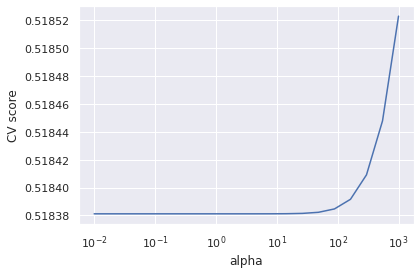

In [254]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import make_scorer

rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False
)

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring=rmse_scorer, cv=5)
searcher.fit(dtrain[numeric_features+categorical], dtrain['log_trip_duration'])

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

Так как долго считается, ограничимся одним шагом поиска (без итеративного уточнения сетки)

Best alpha = 0.0001


Text(0, 0.5, 'CV score')

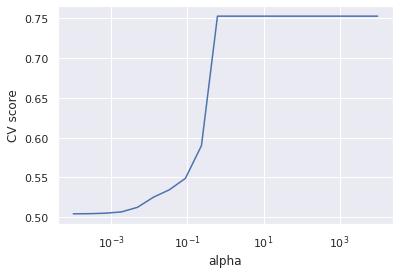

In [257]:
alphas = np.logspace(-4, 4, 20)
searcher = GridSearchCV(lasso_pipeline, [{"regression__alpha": alphas}], scoring=rmse_scorer, cv=5)
searcher.fit(dtrain[numeric_features+categorical], dtrain['log_trip_duration'])

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [258]:
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(alpha = 2.3357))
])

fifth_model = pipeline.fit(dtrain[numeric_features+categorical], dtrain['log_trip_duration'])
y_pred_train = fifth_model.predict(dtrain[numeric_features+categorical])
y_pred = fifth_model.predict(dtest[numeric_features+categorical])
print("Ridge Train RMSE = %.4f" % rmse(dtrain['log_trip_duration'], y_pred_train))
print("Ridge Test RMSE = %.4f" % rmse(dtest['log_trip_duration'], y_pred))



lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(alpha = 0.0001))
])

lasso_model = lasso_pipeline.fit(dtrain[numeric_features+categorical], dtrain['log_trip_duration'])
y_pred_train = lasso_model.predict(dtrain[numeric_features+categorical])
y_pred = lasso_model.predict(dtest[numeric_features+categorical])
print("Lasso Train RMSE = %.4f" % rmse(dtrain['log_trip_duration'], y_pred_train))
print("Lasso Test RMSE = %.4f" % rmse(dtest['log_trip_duration'], y_pred))

Ridge Train RMSE = 0.5043
Ridge Test RMSE = 0.5054
Lasso Train RMSE = 0.5043
Lasso Test RMSE = 0.5055


In [328]:
lasso_zeros = np.sum(lasso_pipeline.steps[-1][-1].coef_ == 0)
print("Zero weights in Lasso:", lasso_zeros)

Zero weights in Lasso: 57


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [330]:
alphas = np.logspace(-4, 4, 20)
lasso_zeros = pd.DataFrame(data={'alpha': alphas, 'zero_coefs': 0})

for alpha_ in alphas:
  lasso_pipeline = Pipeline(steps=[
      ('ohe_and_scaling', column_transformer),
      ('regression', Lasso(alpha = alpha_))
  ])

  lasso_model = lasso_pipeline.fit(dtrain[numeric_features+categorical], dtrain['log_trip_duration'])
  lasso_zeros.loc[lasso_zeros['alpha']==alpha_,'zero_coefs'] = np.sum(lasso_pipeline.steps[-1][-1].coef_ == 0)

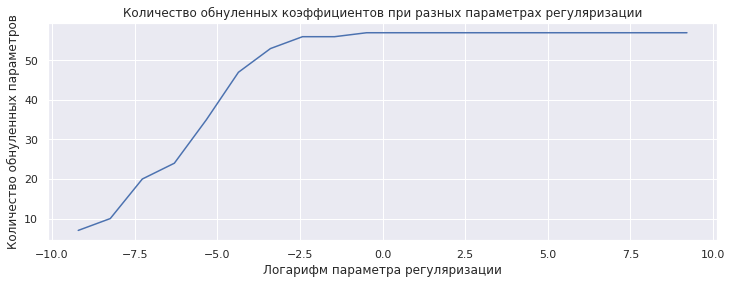

In [326]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(12,4))

plt.plot(np.log(lasso_zeros['alpha']), lasso_zeros['zero_coefs'])
ax.set_title('Количество обнуленных коэффициентов при разных параметрах регуляризации')
ax.set_xlabel('Логарифм параметра регуляризации')
ax.set_ylabel('Количество обнуленных параметров')
ax.grid(True)

plt.show()

Половину признаков мы теряем при выборе альфы хотябы 0.004833 (на нашей сетке). С такой альфой качество:

In [332]:
lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(alpha = 0.004833))
])

lasso_model = lasso_pipeline.fit(dtrain[numeric_features+categorical], dtrain['log_trip_duration'])
y_pred_train = lasso_model.predict(dtrain[numeric_features+categorical])
y_pred = lasso_model.predict(dtest[numeric_features+categorical])
print("Lasso Train RMSE = %.4f" % rmse(dtrain['log_trip_duration'], y_pred_train))
print("Lasso Test RMSE = %.4f" % rmse(dtest['log_trip_duration'], y_pred))

Lasso Train RMSE = 0.5124
Lasso Test RMSE = 0.5136


<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

У нас могут быть стандартные маршруты со стабильным временем. Зная эти маршруты, мы сможем лучше предсказывать время поездки (условно, из квадрата A в квадрат B обычно едут по одним и тем же дорогам, что при контроле за временем позволит хорошо предсказывать время поездки). Потому что это interaction между признаками, а линейная модель не способна его увидеть. 

In [379]:
top_routes = train.groupby(['pickup_cell','dropoff_cell'])['id'].count().\
  to_frame().reset_index().sort_values('id', ascending = False).head(100)
top_routes.drop(columns = 'id', inplace = True)
top_routes['route_code'] = np.arange(1,101) #top_routes['pickup_cell'].astype(str) + ' ' + top_routes['dropoff_cell'].astype(str)
train = train.merge(top_routes, how = 'left', on = ['pickup_cell','dropoff_cell'])
train.loc[train['route_code'].isnull(),'route_code'] = -1

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [381]:
dtrain, dtest = train_test_split(train, test_size = 0.3, random_state = 111)

numeric_features = ['p_month','p_hour','p_date','log_haversine']
categorical = ['p_day','first_anomaly','second_anomaly',
               'pickup_cell','dropoff_cell',
               'open_roads','traffic_jam',
               'air_k_start','air_k_finish','air_n_finish', 'route_code']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(alpha = 2.3357))
])

fourth_model = pipeline.fit(dtrain[numeric_features+categorical], dtrain['log_trip_duration'])
y_pred_train = fourth_model.predict(dtrain[numeric_features+categorical])
y_pred = fourth_model.predict(dtest[numeric_features+categorical])
print("Train RMSE = %.4f" % rmse(dtrain['log_trip_duration'], y_pred_train))
print("Test RMSE = %.4f" % rmse(dtest['log_trip_duration'], y_pred))

Train RMSE = 0.4713
Test RMSE = 0.4723


Ну еще немного выжали:)